<a href="https://colab.research.google.com/github/alohia/pytorch_playground/blob/master/02_basic_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
from torch import tensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### Implement a basic training loop on MNIST using vanilla pytorch and then by using pytorch modules

In [0]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [0]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


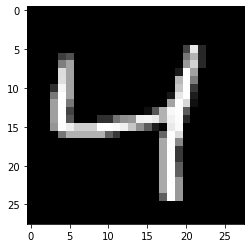

In [4]:
plt.imshow(x_train[2].reshape((28, 28)), cmap="gray")
print(x_train.shape)

In [0]:
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))
n, c = x_train.shape

In [6]:
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


Note:
We are initializing the weights here with `Xavier initialisation` (by multiplying with 1/sqrt(n)).

In [0]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [0]:
def model(xb):
    return xb @ weights + bias

In [0]:
xb1 = x_train[0:2]

In [0]:
o1 = model(xb1)

In [11]:
o1.shape

torch.Size([2, 10])

In [0]:
yb1 = y_train[0:2]

In [13]:
yb1

tensor([5, 0])

In [14]:
o1

tensor([[-0.3269,  0.2778,  0.2604, -0.0270,  0.1084, -0.2805, -0.0399,  0.2193,
          0.3764, -0.1752],
        [-0.0623,  0.5288,  0.5934, -0.2227,  0.4122, -0.2155,  0.1370,  0.2998,
          0.2520, -0.1429]], grad_fn=<AddBackward0>)

First, we will need to compute the softmax of our activations. This is defined by:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{e^{x_{0}} + e^{x_{1}} + \cdots + e^{x_{n-1}}}$$

or more concisely:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum_{0 \leq j \leq n-1} e^{x_{j}}}$$ 

In practice, we will need the log of the softmax when we calculate the loss.

![Loss function](https://ml-cheatsheet.readthedocs.io/en/latest/_images/cross_entropy.png)

In case of multi-class classification, total loss is given as:

$$-\sum_{c=1}^My_{o,c}\log(p_{o,c})$$



*   M - number of classes
*   log - the natural log
*   y - binary indicator (0 or 1) if class label c is the correct classification for observation o
*   p - predicted probability observation o is of class c


In [0]:
def log_softmax(x):
  return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

In [0]:
sm_pred = log_softmax(o1)

In [17]:
sm_pred

tensor([[-2.6957, -2.0910, -2.1084, -2.3958, -2.2604, -2.6493, -2.4087, -2.1495,
         -1.9924, -2.5440],
        [-2.5648, -1.9737, -1.9091, -2.7252, -2.0903, -2.7180, -2.3655, -2.2027,
         -2.2506, -2.6454]], grad_fn=<LogBackward>)

In [18]:
yb1

tensor([5, 0])

In [19]:
sm_pred[[0,1], [5,0]]

tensor([-2.6493, -2.5648], grad_fn=<IndexBackward>)

In [0]:
def nll(input, target):
  return -input[range(target.shape[0]), target].mean()

In [0]:
loss = nll(sm_pred, yb1)

In [22]:
torch.allclose(F.nll_loss(F.log_softmax(o1, -1), yb1), loss)

True

In PyTorch, `F.log_softmax` and `F.nll_loss` are combined in one optimized function, `F.cross_entropy`.

In [23]:
torch.allclose(F.cross_entropy(o1, yb1), loss)

True

In [0]:
loss_func = F.cross_entropy

In [0]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
yb = y_train[0:bs]
preds = model(xb)  # predictions

In [26]:
print(preds[0], preds.shape)

tensor([-0.3269,  0.2778,  0.2604, -0.0270,  0.1084, -0.2805, -0.0399,  0.2193,
         0.3764, -0.1752], grad_fn=<SelectBackward>) torch.Size([64, 10])


In [0]:
# preds.shape is [64,10] because batch of 64 and 10 probs per input

In [0]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [28]:
loss_func(preds, yb)

tensor(2.3232, grad_fn=<NllLossBackward>)

In [29]:
accuracy(preds, yb)

tensor(0.0781)

accuracy is about 10% because model is not trained - so we expect it to be as good as random

In [0]:
lr = 0.5 # learning rate
epochs = 1 # how many epochs to train for

In [0]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        loss = loss_func(model(xb), yb)
        
        loss.backward()
        with torch.no_grad():
          weights -= weights.grad * lr
          bias -= bias.grad * lr
          weights.grad.zero_()
          bias.grad.zero_()

In [34]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1105, grad_fn=<NllLossBackward>), tensor(1.))

## Refactor using nn.Module

In [0]:
from torch import nn

In [0]:
class MyDummyModule(nn.Module):
    def __init__(self, mult_factor):
        super().__init__()
        self.mult_factor = mult_factor

    def forward(self, x):
        return x * self.mult_factor

In [0]:
md = MyDummyModule(5)

In [40]:
md(10)

50

In [0]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

In [0]:
model = Mnist_Logistic()

In [46]:
loss_func(model(xb), yb)

tensor(2.3694, grad_fn=<NllLossBackward>)

In [48]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0113,  0.0075, -0.0334,  ...,  0.0367, -0.0282,  0.0155],
         [-0.0021, -0.0248, -0.0084,  ...,  0.0295,  0.0041,  0.0278],
         [-0.0002, -0.0612, -0.0253,  ...,  0.0261,  0.0133,  0.0044],
         ...,
         [ 0.0060, -0.0677,  0.0238,  ...,  0.0433,  0.0101,  0.0680],
         [ 0.0116, -0.0565,  0.0169,  ..., -0.0100,  0.0324, -0.0067],
         [ 0.0099, -0.0327,  0.0375,  ..., -0.0201,  0.0331, -0.0479]],
        requires_grad=True), Parameter containing:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)]

In [0]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

In [51]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1132, grad_fn=<NllLossBackward>), tensor(1.))

### Refactor using nn.Linear

In [0]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

In [53]:
model = Mnist_Logistic()
loss_func(model(xb), yb)

tensor(2.3957, grad_fn=<NllLossBackward>)

In [54]:
fit()
loss_func(model(xb), yb)

tensor(0.1080, grad_fn=<NllLossBackward>)

### Refactor using optim

In [0]:
from torch import optim

In [56]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.3540, grad_fn=<NllLossBackward>)
tensor(0.1115, grad_fn=<NllLossBackward>)


### Refactor using dataset and dataloader

In [0]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [0]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [59]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.1115, grad_fn=<NllLossBackward>)


### Add validation set

In [0]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [61]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.3447)


In [0]:
epochs = 3

In [66]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)
        valid_acc = sum(accuracy(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, 'loss', valid_loss / len(valid_dl), 'acc', valid_acc/len(valid_dl))

0 loss tensor(0.3529) acc tensor(0.8923)
1 loss tensor(0.3068) acc tensor(0.9114)
2 loss tensor(0.2792) acc tensor(0.9228)


We promised at the start of this tutorial we'd explain through example each of
``torch.nn``, ``torch.optim``, ``Dataset``, and ``DataLoader``. So let's summarize
what we've seen:

 - **torch.nn**

   + ``Module``: creates a callable which behaves like a function, but can also
     contain state(such as neural net layer weights). It knows what ``Parameter`` (s) it
     contains and can zero all their gradients, loop through them for weight updates, etc.
   + ``Parameter``: a wrapper for a tensor that tells a ``Module`` that it has weights
     that need updating during backprop. Only tensors with the `requires_grad` attribute set are updated
   + ``functional``: a module(usually imported into the ``F`` namespace by convention)
     which contains activation functions, loss functions, etc, as well as non-stateful
     versions of layers such as convolutional and linear layers.
 - ``torch.optim``: Contains optimizers such as ``SGD``, which update the weights
   of ``Parameter`` during the backward step
 - ``Dataset``: An abstract interface of objects with a ``__len__`` and a ``__getitem__``,
   including classes provided with Pytorch such as ``TensorDataset``
 - ``DataLoader``: Takes any ``Dataset`` and creates an iterator which returns batches of data.